<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/intro/datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manipulating datasets

In this colab, we briefly discuss ways to access and manipulate common datasets that are used in the ML literature. Most of these are used for supervised learning experiments.


In [2]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

# Tabular datasets

The [UCI ML repository](https://archive.ics.uci.edu/ml/index.php) contains many smallish datasets, mostly tabular.

[Kaggle](https://www.kaggle.com/datasets) also hosts many interesting datasets.

[Sklearn](https://scikit-learn.org/0.16/datasets/index.html) has many small datasets builtin, making them easy to use for prototyping, as we illustrate below.

In [ ]:

from sklearn import datasets

iris = datasets.load_iris()
print(iris.keys())

X = iris['data']
y = iris['target'] # class labels
print(X.shape)
print(iris['feature_names']) # meaning of each feature
print(iris['target_names']) # meaning of each class




dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


# Tensorflow datasets

[TFDS](https://www.tensorflow.org/datasets) is a handy way to handle large datasets as a stream of minibatches, suitable for large scale training and parallel evaluation. It can be used by tensorflow and JAX code, as we illustrate below. (See the [official colab](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) for details.)




In [3]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

from typing import Any, Iterator, Mapping, NamedTuple, Sequence, Tuple

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn


In [4]:

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import tensorflow_datasets as tfds

print("tf version {}".format(tf.__version__))


tf version 2.4.0


In [5]:
import jax
from typing import Any, Callable, Sequence, Optional, Dict, Tuple
import jax.numpy as jnp

rng = jax.random.PRNGKey(0)

In [6]:
# Useful type aliases

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


## Minibatching without using TFDS

We first illustrate how to make streams of minibatches using vanilla numpy code. TFDS will then let us eliminate a lot of this boilerplate. As an example, let's package some small labeled datasets into two dictionaries, for train and test.

In [8]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

def get_datasets_iris():
  iris = sklearn.datasets.load_iris()
  X = iris["data"]
  y = iris["target"] 
  N, D = X.shape # 150, 4
  X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.33, random_state=42)
  train_ds = {'X': X_train, 'y': y_train}
  test_ds = {'X': X_test, 'y': y_test}
  return train_ds, test_ds

train_ds, test_ds = get_datasets_iris()
print(train_ds['X'].shape)
print(train_ds['y'].shape)

(100, 4)
(100,)


In [9]:
iris = sklearn.datasets.load_iris()
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


Now we make one pass (epoch) over the data, computing random minibatches of size 30. There are 100 examples total, but with a batch size of 30,
we don't use all the data. We can solve such "boundary effects" later. 

In [10]:
def extract_batch(ds, ndx):
  batch = {k: v[ndx, ...] for k, v in ds.items()}
  #batch = {'X': ds['X'][ndx,:],  'y': ds['y'][ndx]}
  return batch

def process_epoch(train_ds, batch_size, rng):
  train_ds_size = len(train_ds['X'])
  steps_per_epoch = train_ds_size // batch_size
  perms = jax.random.permutation(rng, len(train_ds['X']))
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size)) # perms[i,:] is list of  data indices for step i
  for step, perm in enumerate(perms):
    batch = extract_batch(train_ds, perm)
    print('processing batch {} X shape {}, y shape {}'.format(
        step, batch['X'].shape, batch['y'].shape))

batch_size = 30
process_epoch(train_ds, batch_size, rng)


processing batch 0 X shape (30, 4), y shape (30,)
processing batch 1 X shape (30, 4), y shape (30,)
processing batch 2 X shape (30, 4), y shape (30,)


## Minibatching with TFDS

Below we show how to convert a numpy array into a TFDS.
We shuffle the records and convert to minibatches, and then repeat these batches indefinitely to create an infinite stream,
which we can convert to a python iterator. We pass this iterator of batches to our training loop.



In [11]:


def load_dataset_iris(split: str, batch_size: int) -> Iterator[Batch]:
  train_ds, test_ds = get_datasets_iris()
  if split == tfds.Split.TRAIN:
    ds = tf.data.Dataset.from_tensor_slices({"X": train_ds["X"], "y": train_ds["y"]})
  elif split == tfds.Split.TEST:
    ds = tf.data.Dataset.from_tensor_slices({"X": test_ds["X"], "y": test_ds["y"]})
  ds = ds.shuffle(buffer_size=1 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.cache()
  ds = ds.repeat() # make infinite stream of batches
  return iter(tfds.as_numpy(ds)) # python iterator

batch_size = 30
train_ds = load_dataset_iris(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset_iris(tfds.Split.TEST, batch_size)

print(train_ds)

training_steps = 5
for step in range(training_steps):
  batch = next(train_ds)
  print('processing batch {} X shape {}, y shape {}'.format(
        step, batch['X'].shape, batch['y'].shape))

<generator object _eager_dataset_iterator at 0x7f849ea3f258>
processing batch 0 X shape (30, 4), y shape (30,)
processing batch 1 X shape (30, 4), y shape (30,)
processing batch 2 X shape (30, 4), y shape (30,)
processing batch 3 X shape (10, 4), y shape (10,)
processing batch 4 X shape (30, 4), y shape (30,)


## Preprocessing the data

We can process the data before creating minibatches.
We can also use pre-fetching to speed things up (see
[this TF tutorial](https://www.tensorflow.org/guide/data_performance) for details.)
We illustrate this below for MNIST.


In [16]:


def process_record(batch):
  image = batch['image']
  label = batch['label']
  # reshape image to standard size, just for fun
  image = tf.image.resize(image, (32, 32))
  # flatten image to vector
  shape = image.get_shape().as_list()
  D = np.prod(shape) # no batch dimension
  image = tf.reshape(image, (D,))
  # rescale to -1..+1
  image = tf.cast(image, dtype=tf.float32)
  image = ((image / 255.) - .5) * 2. 
  # convert to standard names
  return {'X': image, 'y': label} 

def load_mnist(split, batch_size):
  dataset, info = tfds.load("mnist", split=split, with_info=True)
  dataset = dataset.map(process_record)
  if split=="train":
    dataset = dataset.shuffle(10*batch_size, seed=0)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache()
  dataset = dataset.repeat()
  dataset = tfds.as_numpy(dataset) # leave TF behind
  num_examples = info.splits[split].num_examples
  return iter(dataset), num_examples


batch_size = 100
train_iter, num_train = load_mnist("train", batch_size)
test_iter, num_test = load_mnist("test", batch_size)

num_epochs = 3
num_steps = num_train // batch_size 
print(f'{num_epochs} epochs with batch size {batch_size} will take {num_steps} steps')

batch = next(train_iter)
print(batch['X'].shape)
print(batch['y'].shape)

3 epochs with batch size 100 will take 600 steps
(100, 1024)
(100,)


# Vision datasets

## MNIST

There are many standard versions of MNIST,
some of which are available from https://www.tensorflow.org/datasets. We give some examples below.


In [ ]:
ds, info = tfds.load("binarized_mnist", split=tfds.Split.TRAIN, shuffle_files=True, with_info=True)
print(ds)
print(info)

<_OptionsDataset shapes: {image: (28, 28, 1)}, types: {image: tf.uint8}>
tfds.core.DatasetInfo(
    name='binarized_mnist',
    version=1.0.0,
    description='A specific binarization of the MNIST images originally used in
(Salakhutdinov & Murray, 2008). This dataset is frequently used to evaluate
generative models of images, so labels are not provided.',
    homepage='http://www.dmi.usherb.ca/~larocheh/mlpython/_modules/datasets/binarized_mnist.html',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 50000,
        'validation': 10000,
    },
    supervised_keys=None,
    citation="""@inproceedings{salakhutdinov2008quantitative,
    title={On the quantitative analysis of deep belief networks},
    author={Salakhutdinov, Ruslan and Murray, Iain},
    booktitle={Proceedings of the 25th international conference on Machine learning},
    pages={872--879},
    yea

In [ ]:
train_ds, info = tfds.load("mnist", split=tfds.Split.TRAIN, shuffle_files=True, with_info=True)
print(train_ds)
print(info)

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [ ]:
ds = tfds.load('mnist', split='train')
print(type(ds))
ds = ds.take(1)  # Only take a single example
print(type(ds))

for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
['image', 'label']
(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


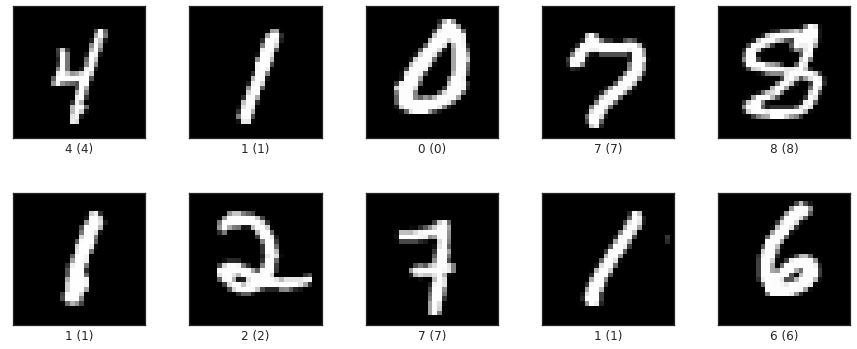

In [ ]:
ds, info = tfds.load('mnist', split='train', with_info=True)
fig = tfds.show_examples(ds, info, rows=2, cols=5)

# This function is not well documented. But source code for show_examples is here:
# https://github.com/tensorflow/datasets/blob/v4.2.0/tensorflow_datasets/core/visualization/image_visualizer.py

## CIFAR

The CIFAR dataset is commonly used for prototyping.
The CIFAR-10 version consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. There is also a 100 class version.

An easy way to get this data is to use TFDS, as we show below.

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteM2APQM/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteM2APQM/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


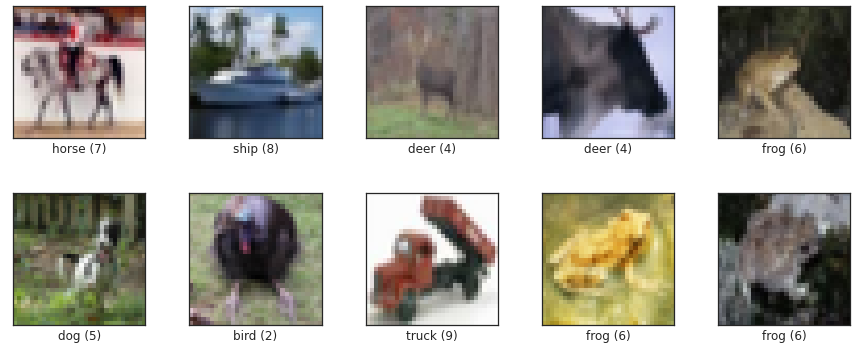

In [ ]:
ds, info = tfds.load('cifar10', split='train', with_info=True)
fig = tfds.show_examples(ds, info, rows=2, cols=5)

## Imagenet

A lot of vision experiments use the Imagenet dataset, with 1000 classes and ~1M images.
However, this takes a long time to download and process.
The FastAI team made a smaller version called [ImageNette](https://github.com/fastai/imagenette), that only has 10 classes of size 160 or 320 pixels (largest dimension). This is good for prototyping, and the images tend to be easier to interpret that CIFAR. A version of the raw data, in a more convenient format (all images 224x224, no dependence on FastAI library) can be found [here](https://github.com/thunderInfy/imagenette). It is also bundled into TFDS, as we show below.

In [ ]:
import tensorflow_datasets as tfds

imagenette_builder = tfds.builder("imagenette/full-size")
imagenette_info = imagenette_builder.info
print(imagenette_info)

imagenette_builder.download_and_prepare()


tfds.core.DatasetInfo(
    name='imagenette',
    version=0.1.0,
    description='Imagenette is a subset of 10 easily classified classes from the Imagenet
dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
behind putting together a small version of the Imagenet dataset was mainly
because running new ideas/algorithms/experiments on the whole Imagenet take a
lot of time.

This version of the dataset allows researchers/practitioners to quickly try out
ideas and share with others. The dataset comes in three variants:

  * Full size
  * 320 px
  * 160 px

Note: The v2 config correspond to the new 70/30 train/valid split (released
in Dec 6 2019).',
    homepage='https://github.com/fastai/imagenette',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=13394,
    splits={
        'train': 12894,
        'validation': 500,
    }

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size/0.1.0.incompleteAGT375/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size/0.1.0.incompleteAGT375/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size/0.1.0. Subsequent calls will reuse this data.


NameError: ignored

In [ ]:
datasets = imagenette_builder.as_dataset(as_supervised=True)

In [ ]:

train_examples = imagenette_info.splits['train'].num_examples
validation_examples = imagenette_info.splits['validation'].num_examples
print('ntrain', train_examples, 'nvalidation', validation_examples)

train, test = datasets['train'], datasets['validation']

import tensorflow as tf
batch_size = 32

train_batch = train.map(
    lambda image, label: (tf.image.resize(image, (448, 448)), label)).shuffle(100).batch(batch_size).repeat()

validation_batch = test.map(
    lambda image, label: (tf.image.resize(image, (448, 448)), label)
).shuffle(100).batch(batch_size).repeat()



ntrain 12894 nvalidation 500


In [ ]:
i = 0
for X, y in train_batch:
  #print(b)
  #X = b['image']
  #y = b['label']
  print('image {}, X shape {}, y shape {}'.format(i, X.shape, y.shape))
  i += 1
  if i > 1: break

image 0, X shape (32, 448, 448, 3), y shape (32,)
image 1, X shape (32, 448, 448, 3), y shape (32,)


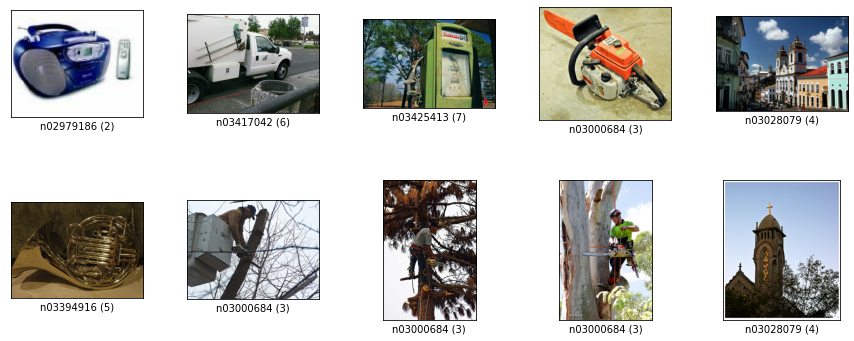

In [ ]:
fig = tfds.show_examples(train, imagenette_info, rows=2, cols=5)

# Language datasets

Various datasets are used in the natural language processing (NLP) communities.

TODO: fill in.

# Graveyard

Here we store some scratch code that you can ignore,

In [ ]:
def get_datasets_mnist():
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds_all = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds_all = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

  num_train = len(train_ds_all['image'])
  train_ds['X'] = jnp.reshape(jnp.float32(train_ds_all['image']) / 255., (num_train, -1))
  train_ds['y'] = train_ds_all['label']

  num_test = len(test_ds_all['image'])
  test_ds['X'] = jnp.reshape(jnp.float32(test_ds['image']) / 255., (num_test, -1))
  test_ds['y'] = test_ds_all['label']

  return train_ds, test_ds

In [ ]:
dataset = load_dataset_iris(tfds.Split.TRAIN, 30)
batches = dataset.repeat().batch(batch_size)

step = 0
num_minibatches = 5
for batch in batches:
    if step >= num_minibatches:
        break
    X, y = batch['image'], batch['label']
    print('processing batch {} X shape {}, y shape {}'.format(
        step, X.shape, y.shape))
    step = step + 1

processing batch 0 X shape (30, 28, 28, 1), y shape (30,)
processing batch 1 X shape (30, 28, 28, 1), y shape (30,)
processing batch 2 X shape (30, 28, 28, 1), y shape (30,)
processing batch 3 X shape (30, 28, 28, 1), y shape (30,)
processing batch 4 X shape (30, 28, 28, 1), y shape (30,)


In [ ]:
print('batchified version v2')
batch_stream = batches.as_numpy_iterator()
for step in range(num_minibatches):
  batch = batch_stream.next()
  X, y = batch['image'], batch['label'] # convert to canonical names
  print('processing batch {} X shape {}, y shape {}'.format(
        step, X.shape, y.shape))
  step = step + 1

batchified version v2
processing batch 0 X shape (30, 28, 28, 1), y shape (30,)
processing batch 1 X shape (30, 28, 28, 1), y shape (30,)
processing batch 2 X shape (30, 28, 28, 1), y shape (30,)
processing batch 3 X shape (30, 28, 28, 1), y shape (30,)
processing batch 4 X shape (30, 28, 28, 1), y shape (30,)


In [ ]:
ds=tfds.as_numpy(train_ds)
print(ds)
for i, batch in enumerate(ds):
  print(type(batch))
  X = batch['image']
  y = batch['label']
  print(X.shape)
  print(y.shape)
  i += 1
  if i > 2: break



ds = tfds.load('mnist', split='train')
ds = ds.take(100)
#ds = tfds.as_numpy(ds)

batches = ds.repeat(2).batch(batch_size)
print(type(batches))
print(batches)

batch_stream = batches.as_numpy_iterator()
print(type(batch_stream))
print(batch_stream)

b = next(batch_stream)
print(type(b))
print(b['image'].shape)

b = batch_stream.next()
print(type(b))
print(b['image'].shape)


ds = tfds.load('mnist', split='train')
batches = ds.repeat().batch(batch_size)
batch_stream = batches.as_numpy_iterator()


def process_stream(stream):
  b = next(stream)
  X = b['image']
  y = b['label']
  d = {'X': X, 'y': y}
  yield d
  
my_stream = process_stream(batch_stream)

b = next(my_stream)
print(type(b))
print(b['X'].shape)

b = my_stream.next()
print(type(b))
print(b['X'].shape)

In [ ]:

def sample_categorical(N, C):
  p = (1/C)*np.ones(C);
  y = np.random.choice(C, size=N, p=p);
  return y

def get_datasets_rnd():
  Ntrain = 1000; Ntest = 1000; D = 5; C = 10;
  train_ds = {'X': np.random.randn(Ntrain, D), 'y': sample_categorical(Ntrain, C)}
  test_ds = {'X': np.random.randn(Ntest, D), 'y': sample_categorical(Ntest, C)}
  return train_ds, test_ds


def get_datasets_logreg(key):
  Ntrain = 1000; Ntest = 1000; D = 5; C = 10;
  W = jax.random.normal(key, (D,C))

  Xtrain = jax.random.normal(key, (Ntrain, D))
  logits = jnp.dot(Xtrain, W)
  ytrain = jax.random.categorical(key, logits)

  Xtest = jax.random.normal(key, (Ntest, D))
  logits = jnp.dot(Xtest, W)
  ytest = jax.random.categorical(key, logits)

  train_ds = {'X': Xtrain, 'y': ytrain}
  test_ds = {'X': Xtest, 'y': ytest}
  return train_ds, test_ds